In [1]:
import numpy as np
import math
import random
import networkx as nx
import os
from matplotlib import pyplot as plt
import pandas as pd

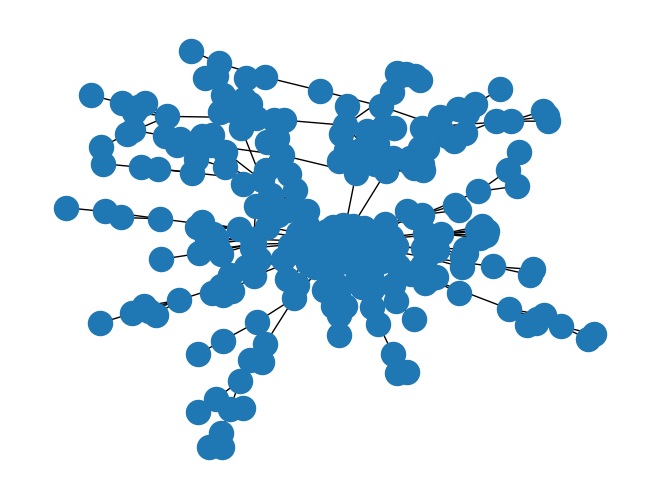

In [2]:
N = 250
topology = "barabasi_albert_graph"

if topology == "scale_free_graph":
    G = nx.scale_free_graph(N)
elif topology == "barabasi_albert_graph":
    G = nx.barabasi_albert_graph(N, m=1)
elif topology == "watts_strogatz_graph":
    G = nx.watts_strogatz_graph(N, k=10, p= 0.1)

assert topology in ["scale_free_graph", "barabasi_albert_graph", "watts_strogatz_graph"]

# choose a layout and parameters
# reference: https://networkx.org/documentation/stable/reference/generated/networkx.drawing.layout.spring_layout.html
pos = nx.spring_layout(G)

# plot and save the graph
nx.draw(G, with_labels=False, pos=pos)
# edge_labels = nx.draw_networkx_edge_labels(G, pos=pos)
figname = f"results/G-{topology}"
plt.savefig(figname)

In [3]:
def run_experiment(experiment_id, parameters):
    N = parameters["N"]
    width = parameters["width"]
    J = parameters["J"]
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    topology = parameters["topology"]
    ts = parameters["ts"]
    warmupiterations = parameters["warmupiterations"]
    simulationiterations = parameters["simulationiterations"]
    # x_interval for figure 2
    return_plot_x_interval = parameters["return_plot_x_interval"]

    #just paramters for the experiment
    
    # assuming rectangular grid
    height = N // width # integer division

    possible_initial_values_of_S = [1, -1]
    possible_initial_values_of_C = [1, -1]

    # initialising the variables used for the simulation for the first time step t = 0

    # S is a 1D grid of 1 row and 1024 columns
    # "for i = 1, ... N, S_i(t) = +- 1"
    # S stores the spins of each trader: +1 is buying and -1 is selling.
    S_t = np.random.choice(possible_initial_values_of_S, (height,width)) # inital values randomly chosen for S

    # C
    C_t= np.random.choice(possible_initial_values_of_C, (height,width)) # inital values randomly chosen for C

    G = None
    if topology == "scale_free_graph":
        G = nx.scale_free_graph(N)
    elif topology == "barabasi_albert_graph":
        G = nx.barabasi_albert_graph(N, parameters["m"])
    elif topology == "watts_strogatz_graph":
        G = nx.watts_strogatz_graph(N, parameters["k"], parameters["p"])

    # calculates and returns an array with the spins, from S, of every neighbouring trader of trader i (row, col)
    # neighbours are traders immediately to the left, right, up or down using the periodic boundary condition
    # i.e. - wrapping around the edges
    def get_neighbours_S_original(S, row, col):
        neighbours_S = []
        if (row > 0):
            neighbours_S.append(S[row-1,col]) # up
        else:
            neighbours_S.append(S[height-1, col])
            
        if (row < height-1): 
            neighbours_S.append(S[row + 1,col]) # down
        else:
            neighbours_S.append(S[ 0, col])
            
        if (col > 0):
            neighbours_S.append(S[row,col-1]) # left
        else: 
            neighbours_S.append(S[row, width -1 ])
        if (col < width-1):
            neighbours_S.append(S[row,col+1]) # right
        else: 
            neighbours_S.append(S[row, 0])
        
        return np.array(neighbours_S)

    def get_neighbours_S_networkx(S, row, col):
        n = row * width + col
     
        # [row,col] -> n
        # [0,0]     -> 0
        # [0,1]     -> 1
        # [0,31]    -> 31  
        # [1,0]     -> 32
        # [
        #     0, 1, 2, 3, .. 31,
        #     32, 33, ...    63
        # ]
        neighbours_S = []
        for neighbor_n in G.neighbors(n):
            if n != neighbor_n: # no self-connections allowed
                # reverse of the above formula
                neighbor_row = neighbor_n // width
                neighbor_col = neighbor_n % width
                
                # look up the spin in S of each neighbour
                neighbours_S.append(S[neighbor_row,neighbor_col])
        return np.array(neighbours_S)

    # Topologies 
    if topology == "original":
        get_neighbours_S = get_neighbours_S_original
    else:
        get_neighbours_S = get_neighbours_S_networkx

    S_tp1 = S_t.copy()
    C_tp1 = C_t.copy()

    # list of Ss at different timestamps in regards to figure 1. 
    Ss = []
    # list of magnetisation at every time step
    Ms = []
    # list of return values - from log calulation - every time step
    rets = []
    # figure 3
    cauda = []

    M_tm1 = 0
    # e.g. warmup might from -100-0, actual iterations 1+
    for t in range(-warmupiterations+1, simulationiterations+1): # for every iteration of the simulation - every time step
        # for the current timestep
        M_t = np.sum(S_t)/N
        if t >= 1: # only record M for simulationiterations (not warmupiterations)
            Ms.append(M_t)

        # monte carlo update means update 1 random trader each simulation step
        row = random.randint(0, height-1)
        col = random.randint(0, width-1)
        
        # h_i(t) local field for trader i at timestep t
        # sum over all traders j (J_ij * S_j) where J_ij checks if i is a neigbour of J
        # = (sum over all neighbours of i (S_neighbour)) * J
        # summing over everything and multiplying non-neighbours by 0 is the same as only summing over neighbours
        h_t = np.sum(get_neighbours_S(S_t, row, col)) * J - alpha * C_t[row,col] * M_t

        # p
        p = 1/(1+math.exp(-2*beta*h_t))

        # "For every spin S_i that is updated, the strategy spin C_i is updated subsequently."

        # update S_i
        S_tp1[row,col] = random.choices([1, -1], weights = [p, 1-p], k=1)[0]

        # update C_i
        if alpha * S_t[row, col] * C_t[row,col] * np.sum(S_t) < 0:
            C_tp1[row,col] = C_t[row,col] * -1

        # move to next timestep
        S_t = S_tp1.copy()
        C_t = C_tp1.copy()
        ret_t = np.log(abs(M_t))-np.log(abs(M_tm1)) #return is the difference between log absolute mag (every timestep)
        M_tm1 = M_t

        # capture the spins at specific times for figure 1
        if t in ts:
            Ss.append(S_t.copy())
        
        # for figure 3, from https://github.com/StxGuy/Econophysics/blob/main/source/Bornholdt.py
        if t >= 1 and not math.isinf(ret_t):
            rets.append(ret_t)
            if (ret_t > 0):
                cauda.append(ret_t)            
        
    
    # structure of code obtained from: https://github.com/lrsppp/bornholdt_model
    fig, ax = plt.subplots(1, len(ts), sharey=True, figsize=(12, 4))
    cmap = plt.get_cmap('Greys', 2) # black and white colour mapping
    for i in range(len(ts)):
        im = ax[i].imshow(Ss[i], cmap=cmap)
        ax[i].set_title(r'$t = %s$' % ts[i])
        cbar = fig.colorbar(im, ax=ax[i], ticks = [0, 1])
        cbar.ax.set_yticklabels(['Sell', 'Buy'])
    plt.tight_layout()
    figname = f"snapshots-{experiment_id}"
    # plt.savefig(f'results/{figname}.pdf')
    plt.savefig(f'results/{figname}.jpeg')

    plt.figure()
    plt.xlabel('Time')
    plt.ylabel('Returns/Logarithmic relative change of Magnetisation')
    # print(rets)
    plt.plot(range(len(rets)//2,len(rets),return_plot_x_interval),rets[len(rets)//2:len(rets):return_plot_x_interval])
    figname = f"return-{experiment_id}"
    # plt.savefig(f'results/{figname}.pdf')
    plt.savefig(f'results/{figname}.jpeg')

    # https://github.com/StxGuy/Econophysics/blob/main/source/Bornholdt.py - plot obtained from this repo.
    plt.figure()
    plt.xlabel('Returns')
    plt.ylabel('Cumulative Distribution of Returns')
    mi = min(rets)
    ma = max(rets)
    x = np.linspace(mi,ma,100)
    y = []
    for ex in x:
        y.append(1.0-float(sum(cauda<ex))/len(cauda))
    plt.loglog(x,y, '.')
    figname = f"cumdistribution-{experiment_id}"
    # plt.savefig(f'results/{figname}.pdf')
    plt.savefig(f'results/{figname}.jpeg')

    # print(f"experiment {experiment_id}")
    # print(f"mean of M: {np.mean(np.array(Ms))}")
    # print(f"variance of M: {np.var(np.array(Ms))}")

In [ ]:
def delete_files_in_directory(directory_path):
    try:
        files = os.listdir(directory_path)
        for file in files:
            file_path = os.path.join(directory_path, file)
            if os.path.isfile(file_path):
                os.remove(file_path)
        print("All files deleted successfully.")
    except OSError:
        print("Error occurred while deleting files.")
delete_files_in_directory('results')


# barabaze m=1

run_experiment(
    experiment_id=1,
        parameters={
        "N": 1024, # to fill a 32 * 32 2D grid
        "width": 32, 
        "J": 1 ,
        "alpha": 4,
        "beta": 1/1.5,
        "topology": "original",
        "ts": [611, 2046, 2913, 3527],
        "warmupiterations": int(0),
        "simulationiterations": int(8000),
        "return_plot_x_interval": 1
    }
)

run_experiment(
    experiment_id=2,
    parameters={
        "N": 1024,
        "width": 32,   
        "J": 1,
        "alpha": 4,
        "beta": 1/1.5,
        "topology": "barabasi_albert_graph",
        "m": 1,
        "ts": [611, 2046, 2913, 3527],
        "warmupiterations": int(0),
        "simulationiterations": int(8000),
        "return_plot_x_interval": 1
    }
)

run_experiment(
    experiment_id=3,
    parameters={
        # N is the total number of traders
        "N": 1024, # to fill a 32 * 32 2D grid
        "width": 32,   
        "J": 1,
        "alpha": 4,
        "beta": 1/1.5,
        "topology": "watts_strogatz_graph",
        "k": 30,
        "p": 0.1,
        "ts": [611, 2046, 2913, 3527],
        "warmupiterations": int(0),
        "simulationiterations": int(8000),
        "return_plot_x_interval": 1
    }
)
run_experiment(
    experiment_id=4,
        parameters={
        # N is the total number of traders
        "N": 1024, # to fill a 32 * 32 2D grid
        "width": 32, 
        "J": 1 ,
        "alpha": 4,
        "beta": 1/1.5,
        "topology": "scale_free_graph",
        "ts": [611, 2046, 2913, 3527],
        "warmupiterations": int(0),
        "simulationiterations": int(8000),
        "return_plot_x_interval": 1
    }
)